In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [162]:
class GMM():
    def __init__(self, n_components, data):
        self.num_data = data.shape[0]
        self.dimension = data.shape[1]
        self.data = data
        self.components = n_components
        self.means = self.initialize_means()
        self.covariances = self.initialize_variances()
        self.lambdas = self.initialize_lambdas()
            
    
    def initialize_means(self): 
        random_choice = np.random.choice(self.num_data, self.components, replace = False)
        means_ = self.data[random_choice]
        return means_
        
    def initialize_variances(self):
        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            covariances_[i] = np.cov(self.data, rowvar = False)
        return covariances_    
    
    def initialize_lambdas(self):
        return np.ones([self.components]) / float(self.components)
        
        
    def initialize_gammas(self):
        """Initializes gammas to random values maintaining their sum = 1 for each component"""
        gammas_ = np.random.rand(self.components, self.num_data)
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
        
    def calculate_means(self):
        """Calculates the means based on the current values of gammas"""
#         print(self.num_data, self.components, self.dimension)
        means_ = np.zeros((self.components, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                means_[i] += self.gammas[i][j] * self.data[j] / self.gammas[i].sum()
        return means_
        
    def calculate_variances(self):
        """Calculates the covariances based on the current values of gammas"""

        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                covariances_[i] += self.gammas[i][j] * np.dot((self.data[j] - self.means[i]).reshape(-1, 1), (self.data[j] - self.means[i]).reshape(-1, 1).T) / self.gammas[i].sum()
                if np.log(np.linalg.det(covariances_[i])) < -800:
#                     print(np.power(np.e, -20))
#                     print("Entering {}".format(np.log(np.linalg.det(covariances_[i]))))
                    covariances_[i] = np.cov(self.data, rowvar = False) / 100.
                    self.means[i] = self.data[np.random.choice(self.num_data)]
        return covariances_
    
    def calculate_lambdas(self):
        """Updates lambdas based on the values of gamma"""
        return self.gammas.sum(1)/self.gammas.sum()
    
    def calculate_gammas(self):
        """Updates gammas based on the values of the means, covariances and lambdas"""
        gammas_ = np.zeros((self.components, self.num_data))
        for i in range(self.components):
            for j in range(self.num_data):
                gammas_[i, j] = self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
    
    def calculate_likelihood(self):
        """Calculates the likelihood of data given parameters. We need to stop EM when likelihood saturates"""
        prb = np.zeros((self.num_data))
        for j in range(self.num_data):
            for i in range(self.components):
                prb[j] += self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        likelihood_ = np.sum(np.log(prb))
#         print("Likelihood {}".format(likelihood_))
        return likelihood_
    
    def gaussian_probability(self, x_, mu_, sigma_):
        """Given the datapoint, mean for the component and the variance matrix of the component, calculates the probability"""
        x_ = x_.reshape(-1, 1)
        mu_ = mu_.reshape(-1, 1)

        prob_ = (1. / (np.power(2 * np.pi, self.dimension / 2.) * np.power(np.linalg.det(sigma_), 0.5))) * np.exp(- 0.5 * np.dot((x_ - mu_).T, np.dot(np.linalg.inv(sigma_), (x_ - mu_))))
        prob_ = float(prob_.reshape(1))
#         print(prob_)
        return prob_

    def generate_data(self, n_data):
        """creates a list of data points"""    
    
        data_ = np.zeros((n_data, self.dimension))
        for i in range(n_data):
            # pick a cluster id and create data from this cluster
            k = np.random.choice(self.components, size = 1, p = self.lambdas)[0]
            x = np.random.multivariate_normal(self.means[k], self.covariances[k])
            data_[i] = x

        return data_


    def EM(self, max_iter):
        likelihood_list = []
        converged = False
        for i in range(max_iter):
            self.gammas = self.calculate_gammas() # E STEP
            self.means = self.calculate_means() # M STEP
            self.covariances = self.calculate_variances() # M STEP
            self.lambdas = self.calculate_lambdas() # M STEP
            likelihood_list.append(self.calculate_likelihood()) #CALCULATE LIKELIHOOD
            if i % (max_iter / 20) == 0:
                print("Iteration {}, Log Likelihood {}".format(i, likelihood_list[-1]))
            if len(likelihood_list) > 10:
#                 for i in range(10, 5):
                if likelihood_list[-25] => likelihood_list[-1]:
                    print("Converged")
                    converged = True
            if converged:
                break
        return likelihood_list

### Data Preparation and Initialization

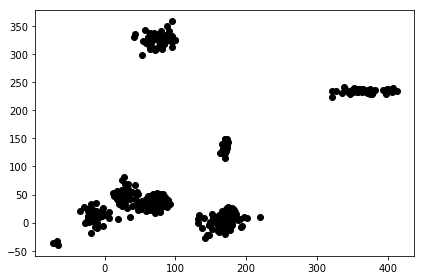

In [169]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data


# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [30, 50],
    [-15, 10],
    [70, 35],
    [70, 325],
    [170, 5],
    [370, 235],
    [170, 135],
    [-70, -35],
])

init_covariances = np.array([
    [[128.5, 0.], [0, 232.5]],
    [[75.92, 6.38], [6.38, 102.91]],
    [[105.5, 20.2], [20.2, 55.5]],
    [[175.92, 36.38], [36.38, 129.1]],
    [[275.92, 45.38], [45.38, 102.91]],
    [[375.92, 6.38], [6.38, 10.91]],
    [[5.92, 16.38], [16.38, 102.91]],
    [[35.92, 6.38], [6.38, 12.91]]
])

init_weights = [.1, .1, .25, .1, .2, .125, .12, .005]

# generate data
# np.random.seed(4)
X = generate_data(500, init_means, init_covariances, init_weights)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()
plt.show()

### Initializing Model on the Data

In [187]:
# X = np.random.rand(1000, 5) * 100

mod = GMM(8, X)

### Initial Parameters of the model

In [188]:
mod.covariances

array([[[ 10152.30086548,   3976.55732821],
        [  3976.55732821,  11267.44255165]],

       [[ 10152.30086548,   3976.55732821],
        [  3976.55732821,  11267.44255165]],

       [[ 10152.30086548,   3976.55732821],
        [  3976.55732821,  11267.44255165]],

       [[ 10152.30086548,   3976.55732821],
        [  3976.55732821,  11267.44255165]],

       [[ 10152.30086548,   3976.55732821],
        [  3976.55732821,  11267.44255165]],

       [[ 10152.30086548,   3976.55732821],
        [  3976.55732821,  11267.44255165]],

       [[ 10152.30086548,   3976.55732821],
        [  3976.55732821,  11267.44255165]],

       [[ 10152.30086548,   3976.55732821],
        [  3976.55732821,  11267.44255165]]])

In [189]:
mod.means

array([[  64.3876436 ,   38.18725714],
       [  70.59509255,   26.99840139],
       [ 173.55309218,  133.16473432],
       [ -14.2604749 ,   18.20456738],
       [  57.80825214,   27.79588421],
       [  47.39198066,   22.46090031],
       [  71.82439473,   37.34799124],
       [ 170.39105718,  148.14486605]])

In [190]:
mod.lambdas

array([ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125])

### Running EM on the GMM

Log Likelihoods in every iteration are printed

In [ ]:
likelihoods = mod.EM(500)

/home/krishanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log


Iteration 0, Log Likelihood -5930.95600887


/home/krishanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


Iteration 25, Log Likelihood -4816.43176944
Iteration 50, Log Likelihood -4832.99858121
Iteration 75, Log Likelihood -4947.7769838
Iteration 100, Log Likelihood -4805.58647068
Iteration 125, Log Likelihood -4783.48161518
Iteration 150, Log Likelihood -4708.2908033
Iteration 175, Log Likelihood -4907.26299498
Iteration 200, Log Likelihood -4832.84350244
Iteration 225, Log Likelihood -4793.58066477
Iteration 250, Log Likelihood -4669.59032048
Iteration 275, Log Likelihood -4837.69011703
Iteration 300, Log Likelihood -4579.83392166
Iteration 325, Log Likelihood -4827.33361565
Iteration 350, Log Likelihood -4879.60429967
Iteration 375, Log Likelihood -4738.74229922
Iteration 400, Log Likelihood -4654.85849736
Iteration 425, Log Likelihood -4894.21031342
Iteration 450, Log Likelihood -4847.6272423


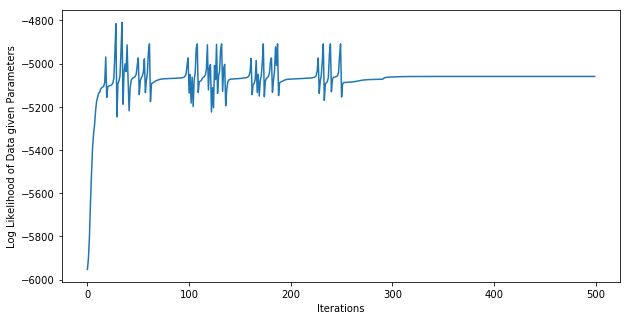

In [175]:
plt.figure(figsize=(10, 5))
plt.plot(likelihoods)
plt.ylabel("Log Likelihood of Data given Parameters")
plt.xlabel("Iterations")
plt.show()

### Model parameters after EM

In [176]:
mod.covariances

array([[[  3.29599845e+03,  -9.69416918e+02],
        [ -9.69416918e+02,   4.19542054e+02]],

       [[  1.11212075e+04,   5.58979196e+03],
        [  5.58979196e+03,   2.89638098e+03]],

       [[  1.80991295e+02,   1.60980585e+01],
        [  1.60980585e+01,   1.23062825e+02]],

       [[  5.81288633e+01,   4.18811658e+00],
        [  4.18811658e+00,   7.32954221e+01]],

       [[  1.41198896e+03,   7.44134653e+02],
        [  7.44134653e+02,   4.26578803e+02]]])

In [177]:
mod.lambdas

array([ 0.43576025,  0.22307704,  0.106     ,  0.09406176,  0.14110095])

In [178]:
mod.means

array([[ 106.42252553,   24.43122852],
       [ 242.63396632,  171.55918777],
       [  74.79822781,  325.96254461],
       [ -15.10711087,   14.42685984],
       [  51.90360291,   28.08784625]])

In [185]:
gen_data = mod.generate_data(1000)

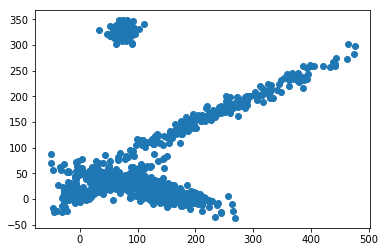

In [186]:
plt.scatter(gen_data[:, 0], gen_data[:, 1])
plt.show()